<a href="https://colab.research.google.com/github/michael-go/handcrafted/blob/main/HandCrafted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: this is a fork of the super cool notebook from https://github.com/newhouseb/handcrafted

This fork adds a small extension starting from: [Output result in natural (not reversed) order](#scrollTo=c8095559)

----

> _What I cannot create, I do not understand_ - Richard Feynmann

**TL;DR: I explain a transformer as a kind of "virtual machine" and then choose weights to make one execute long-form addition the way humans do.**

Quick Nav (only works on Google Colab, click the above link to "Open in Colab" if you're on GitHub first):

- [Transformers as virtual machines](#Transformers-as-Virtual-Machines)
- [Transformer machine state](#Virtual-Machine-State)
- [Instruction types](#Virtual-Machine-Instructions)
- [Attention Instructions](#Attention-Layers)
- [Fully Connected Instructions](#Fully-Connected-Layers)
- [The Naive Algorithm](#Our-First-Algorithm)
- [Reflections](#Reflections)
- [Further Reading](#Further-Reading)

# Hand-Crafted Transformers

People say that we (society) have "no idea" how large language models work. And while we _did_ create these models, we only designed their architectures and their infrastructure. We didn't choose the weights: some variation of gradient descent did.

_**But what if we did?**_

This notebook (alongside future ones) is an educational exercise to build intuitions in the following way:

1. What kinds of computations are easy or hard for modern transformer models to do?
2. If we hand design a model and then traditionally train the same model, do the resulting models operating in a similar way?
3. If they aren't the same -- what changes could we make to bring them closer? 
   - Are there approaches that trained model can teach us? 
   - Are there ways to constrain the trained model?

## Quick Housekeeping

This code relies on your usual combination of PyTorch, NumPy and matplotlib. First we'll import the right bits and then write a couple functions to plot 2-dimensional tensors visually as a grid where each cell represents a value in the tensor ranging from lowest (purple) to highest (yellow).

In [1]:
import itertools
import torch
import torch.nn.functional as F
import math
import torch.nn
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(tensor, title=None, vmax=None):
    fig, ax = plt.subplots()
    data = tensor.detach().cpu() 
    im = ax.imshow(data, cmap='viridis', vmax=vmax)
    im_ratio = data.shape[0]/data.shape[1]
    plt.colorbar(im, cmap='viridis', fraction=0.047 * im_ratio)
    plt.title(title)
    plt.show()
    
def plot_tensor_array(tensor_list, figsize=(80, 20)):
    num_images = len(tensor_list)
    plt.figure(figsize=figsize)
    for idx, img in enumerate(tensor_list):
        plt.subplot(1, num_images, idx + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap='viridis')

    plt.show()

# Our First Task: Addition

It's a bit of a meme that "language models can't do math." And while GPT4 etc is generally much better at this, let's do it with a _much_ smaller model.

In this instance the sample data that the model is going to learn how to "predict" is generated with the following function:

In [2]:
def random_addition():
    # Random numbers from [0,999]
    left = int(np.random.rand()*999)
    right = int(np.random.rand()*999)

    # Zero pad everything to 4 digits
    out = str(left + right).zfill(4)[::-1] # The output is emitted lowest significant digit first (in reverse)
    left = str(left).zfill(4)
    right = str(right).zfill(4)
    
    return left + '+' + right + '=' + out
    
random_addition()

'0560+0374=4390'

To make things easier, I’ve made some simplifying assumptions:

1. **I pad numbers with zeroes up to 4 digits**
This means I don’t have to “hallucinate” zeros at certain decimal places when summing numbers with different numbers of digits.
2. **I don’t put any spaces to the left of `+` and `=`**
This makes “finding” the least significant digit a bit easer
3. **The digits are emitted in “reverse” order**
This is analogous to how we learn to do things in grade school: right to left under the two numbers stacked on top of each other.

With that set up, let's talk about how one can conceptualize building a transformer.

<a name="Transformers-as-Virtual-Machines"></a>
# Transformers as Virtual Machines

Transformers are a class of neural network architectures that use what are called "residual connections." What this means is that rather than each layer taking inputs and emitting entirely "new" outputs, the layers are instead configured to emit _updates_ against the inputs.

So rather than

```
x = layer3(layer2(layer1(x)))
```

A "residual" configuration would be

```
x = layer1(x) + x
x = layer2(x) + x
x = layer3(x) + x
```

This was originally introduced in 2015 in ResNet to improve the training to and prevent issues with vanishing gradients. The nice thing about this _for our purposes_ is that in a residual network, the starting point for a layer that does nothing is a layer with all zeros as weights. In a traditionally deep network, we would need to design each layer to do whatever we intend _while also passing through any other state we don't care about_.

Said another way, we can think of each layer as executing an instruction that mutates some specific state, like "move some data from here to here." 

But where is "here" in this example? For this we need elaborate on how we construct our "state" (the `x` in the above explanations).

<a name="Virtual-Machine-State"></a>
# Virtual Machine State

In a transformer, the state that is passed between layers is a list of numbers of fixed length associated with each token. This might look something like this (all the numbers are made up)

| Token | 0   | 1   | 2   | 3   |
|-------|-----|-----|-----|-----|
| I     | 0.9 | 0.1 | 0.2 | 0.1 |
| Love  | 0.1 | 0.4 | 0.3 | 0.1 |
| You   | 0.5 | 0.3 | 0.4 | 0.2 |

In a traditional network, the significance of certain numbers in certain positions are "learned." In our context, we're going to define what they mean in terms of "registers" analogous to how computers conceptualize them. If you're not familiar with computer architecture, just think of a register as a labelled place in memory.

In our use case, we'll need a number of different registers, for example:

1. A register representing the value of a token (i.e. which number or symbol is this token?)
2. A register representing the position of a token
3. A register representing whether we're currently "carrying a one"

**An important aside about "superposition"**

In learned networks, one component, layer or state may be used for many different purposes. As an analogy, say you have a basket. You could put many things in it: bananas, eggs, etc. Without watching the basket while its in use, it's very difficult to know what the basket is used for. This is partly why learned networks are so darn hard to understand. In our engineered network, however, we are going to minimize this reuse. To stretch the metaphor, if we needed to move around eggs and bananas, we would define an egg-specific basket and a banana-specific basket.

<a name="Virtual-Machine-Instructions"></a>
# Virtual Machine Instructions

Transformers give us two major classes of instructions:

**Attention Layers** - These layers allow us to update a token's state by merging state _from previous tokens_.
   
   If you haven't read other explanations of attention, the way this works is effectively as follows: 
   - A given token's state is used in combination with each other tokens' state to determine how **relevant** a given previous token is to given token's state.
   - The states of all previous tokens are then weighted and summed according to their **relevance** 
   - Specific parts of the resulting summed state are added to the original token's state.

Note that in a traditional transformer, you have multiple separate "attention heads" that perform attention across different selections of registers. I suspect this is mainly valuable because transformers need to learn many different algorithms in order to predict random text. Because we're building a single-purpose transformer, however, we only need one "head".
   
**Fully Connected Layers** - These layers allow us to update a token's state in some arbitrary way _based only on that token's own state_. 

   If you're not familiar with neural networks, here's the quick summary: each output is the result of weighting each input according to a specific set of weights and then summing them up. To a first order (meaning: this is a simplication) if the sum is less than zero, then the output is replaced with zero. This "non-linearity" allows us to mask out state that's not relevant and perform all sorts of "general" computation.
   
Alright, with all that "theory" out of the way, let's get coding.

First, we'll define a register that has a name and a size. Later, we'll map each register to a location (i.e. offset) in the token state.

In [3]:
class Register(object):
    def __init__(self, name, size):
        self.name = name
        self.size = size
        self.offset = None

Next, we'll construct our state. In a traditional model, the thing that one does after splitting up text into tokens is to map those tokens into state. This is called "embedding" the tokens into the model's representation. Often this mapping is learned through training.  In our case we'll explicitly design it:

**Token Value:** Our token's value will be encoded as a "one-hot" register that has as many numbers as we have tokens. So let's say our tokens were 1, 2, 3, a, b, c, then the mapping might look like:


| Token | 0 | 1 | 2 | 3 | 4 | 5 |
|-------|---|---|---|---|---|---|
| 1     | 1 | 0 | 0 | 0 | 0 | 0 |
| 2     | 0 | 1 | 0 | 0 | 0 | 0 |
| 3     | 0 | 0 | 1 | 0 | 0 | 0 |
| a     | 0 | 0 | 0 | 1 | 0 | 0 |
| b     | 0 | 0 | 0 | 0 | 1 | 0 |
| c     | 0 | 0 | 0 | 0 | 0 | 1 |

**Token Position:** Position is a bit more complicated. Modern transformers use all sort of different methods to store positional information in a token. You would be tempted to just store the index of the token in the string but that poses problems because in typical transformer models there is a lot of normalization where at various points you say "take all the numbers in the state here and rescale them to be in the range 0 to 1." If you have a large number that represents an offset that is the biggest number, it'll be scaled down to 1 and no longer represent the position.

A common approach to solving this is to use some form of trigonometry to store a rotated vector rather than an absolute number. So conceptually, imagine for the first token we store the X and Y coordinates of a unit vector rotated by 1 degree. For the second we store the X and Y coordinates of a unit vector rotated by 2 degrees, the 3rd token is for a 3 degree rotation, etc. This obviously has its limits (once strings get really long), but it'll do for our now. Notably, the positional coordinates are all between 0 and 1 (again, for sufficiently short strings).

| Position | X         | Y         |
|----------|-----------|-----------|
| 1st      | cos(1deg) | sin(1deg) |
| 2nd      | cos(2deg) | sin(2deg) |
| 3rd      | cos(3deg) | sin(3deg) |

The following code takes care of this initialization as well as:

- Mapping a set of registers to offsets in the token state (a.k.a. residual stream)
- Providing a method to read the final state and use the state from the last token to determine the last token.

In [4]:
class EmbeddedState(object):
    def __init__(self, tokens: list[str], registers: list[Register]):
        self.tokens = tokens
        self.token_map = { t: i for i,t in enumerate(tokens) }
        self.registers = registers
        self.register_map = {}
        self.register_size = 0
        
        if len(registers) == 0 or registers[0].name != 'pos':
            raise Exception("First register must be 'pos'") 
        
        offset = len(tokens)
        for reg in registers:
            reg.offset = offset
            offset += reg.size
            self.register_size += reg.size
            self.register_map[reg.name] = reg
            
        self.dim = len(tokens) + self.register_size

    def tokenize(self, string: str):
        return torch.tensor([self.token_map[c] for c in string])

    def one_hot(self, sequence):
        return F.one_hot(sequence, num_classes=len(self.tokens)).float()

    def embed(self, sequence):
        tokens_onehot = self.one_hot(sequence)
        # We want to create additional space to store the registers
        extension_tensor = torch.zeros(*tokens_onehot.shape[:-1], self.register_size)

        # Encode position in the first extra embedding dimension
        for i in range(sequence.shape[0]):
            extension_tensor[i, 0] = math.sin(i*(2*math.pi)/100)
            extension_tensor[i, 1] = math.cos(i*(2*math.pi)/100)

        embedding = torch.cat((tokens_onehot, extension_tensor), dim=-1)
        return embedding
    
    def predict(self, sequence):
        return self.tokens[torch.argmax(sequence[-1,:len(self.tokens)])]

As a basic example of how this works, lets take '1+1=2' and "embed" this into our state, and then plot our state.

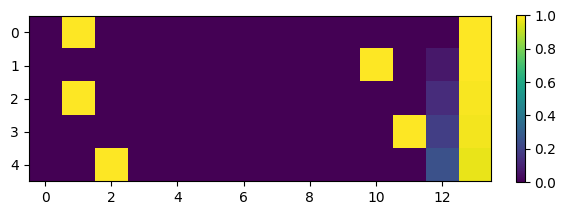

In [5]:
tokens = list('0123456789+=')
pos = Register('pos', 2)

embedding = EmbeddedState(tokens, [pos])
plot_tensor(embedding.embed(embedding.tokenize('1+1=2')))

We'll be plotting graphs like these a lot so it's important to build an intution on how to read these:

- Each square represents a value in a matrix. Yellow is the largest value, purple the lowest.
- The rows are tokens.
- The columns are registers.
- The first 14 or so columns are part of the base 'token' register.
- The last two columns (in this embedding) is the 'rotation' register.

Next, we need to set up the base instruction classes for Attention and Fully Connected Layer. We'll start with the Attention Layer-based instructions and then moved on the fully connected layer instructions. It might not be obvious how these all fit together. We'll get there.

<a name="Attention-Layers"></a>
## Attention Layers

In [6]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, q, k, v):
        super().__init__()
        
        self.q = torch.nn.Parameter(q)
        self.k = torch.nn.Parameter(k)
        self.v = torch.nn.Parameter(v)
        self.softmax = torch.nn.Softmax(dim=2)
        
    def forward(self, seq):
        batch_size, seq_length, dim = seq.shape
        
        q = seq @ self.q
        k = seq @ self.k
        v = seq @ self.v

        causal_mask = (torch.triu(torch.ones(seq_length, seq_length), diagonal=1)*-1e11).to(seq.device)
        norm = np.sqrt(dim)

        kq = self.softmax(q @ k.transpose(-2, -1) / norm + causal_mask)
        s = kq @ v
        return (seq + s)

This is more or less a classic Self Attention layer implementation. If you're not familiar, a high level description (adapted to our "Virtual Machine" context is)

1. The query weights specify what registers for a particular token we want to use to decide what other tokens are relevent.
2. The key weights (key as in "lookup index", not "lock") modify the token state so that the query can index into the tokens appropriately and compute relevancy.
3. With the key and query multiplied together we get a relevance score from each token to each other token. 
4. Because the goal of a model is to predict the next token, we need to force future relevant tokens to be irrelevant, otherwise the model would just learn that the next token... is the one after the current one. This is the "causal mask" from above.
5. Next, we reweight the relevence scores per token to sum to one using softmax.
6. Finally, we use value weights to select which registers we want to add to our state from each token and then use the relevance scores to mix these registers together.

A subtle thing to note here is that this process is run in parallel for each token.

Now let's use this to create our first instruction:

### Find Token and Store Position

Find and store is a layer that stores the position of a particular token in a particular register. To do this, we set up our weights as follows:

- **key** - This is just the identity matrix, we don't need anything fancy.
- **query** - This is a matrix that rewards having the one-hot index related to your token and penalizes everything else.
- **value** - This matrix takes the position register from the relevant token and moves it to the specified output register

In [7]:
class FindToken(AttentionLayer):
    def __init__(self, embedding: EmbeddedState, token: str, register: Register):
        token_select = torch.zeros(embedding.dim, embedding.dim)
        token_select[
            0:len(embedding.tokens), int(embedding.token_map[token])] = 1e10

        pos_reg = embedding.register_map['pos']
        position_select = torch.zeros(embedding.dim, embedding.dim)
        position_select[pos_reg.offset, register.offset] = 1.0
        position_select[pos_reg.offset + 1, register.offset + 1] = 1.0
        
        # q matches only the token we are looking for
        q = token_select
        k = torch.eye(embedding.dim)
        # v moves the token pos register to the target register
        v = position_select    
        
        super().__init__(k=k, v=v, q=q)

Let's break this down a bit with an example of using this layer to find and store the position of the plus sign

In [8]:
tokens = list('0123456789+=')
pos = Register('pos', 2)
plus_pos = Register('plus_pos', 2)

embedding = EmbeddedState(tokens, [pos, plus_pos])
find_plus = FindToken(embedding, '+', plus_pos)

x = embedding.embed(embedding.tokenize('1+1=2'))

First we'll plot the (non-identity) weights

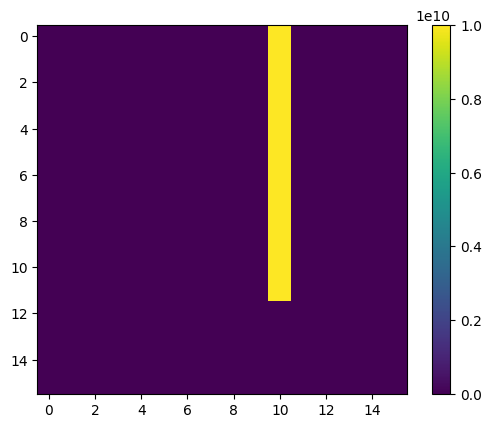

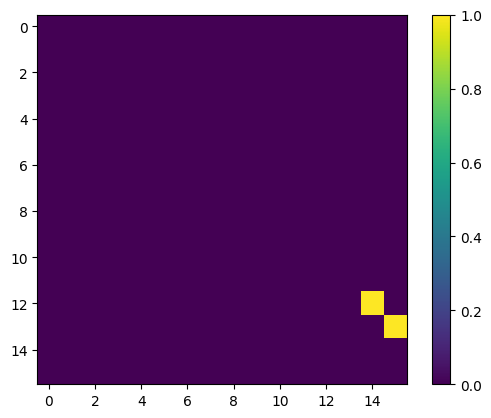

In [9]:
plot_tensor(find_plus.q)
plot_tensor(find_plus.v)

For the query, regardless of the source token, we're looking for a token that has the 11th column (representing plus) lit up.

For the value, we're simply moving whatever is in the 14th and 15th columns of the relevant token into the 16th and 17th columns of the output token.

Next, let's look at what the relevant from one token is to another in our simple "1+1=2" example

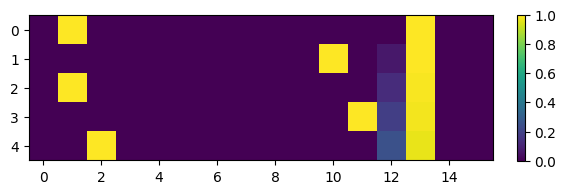

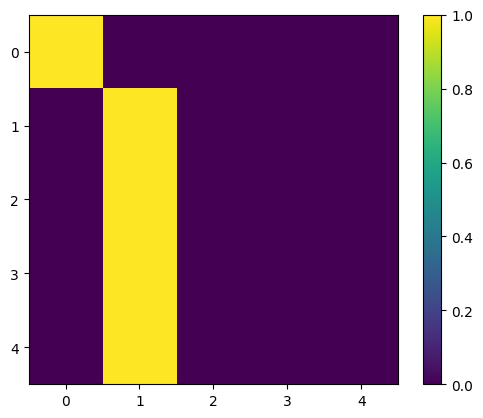

In [10]:
plot_tensor(x)

# For simplicity, I've pulled out the core math from that layer
plot_tensor(torch.nn.Softmax(1)(((x @ find_plus.q) @ (x @ find_plus.k).T) + torch.triu(torch.ones(5, 5), diagonal=1)*-1e11))

As we would expect,  all* tokens find the 3rd token most relevant... which is where the plus sign is.

\*You'll note that tokens before the plus sign are...confused. This is because the causal mask has prevented these tokens from "seeing" the tokens in the future.

Now let's look at the full layer in action:

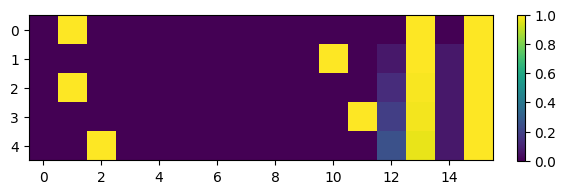

In [11]:
# There's a little bit of extra work to put the example in a batch of size 1 and then take it out
plot_tensor(find_plus.forward(x.unsqueeze(0))[0])

As we hoped, the position of the plus sign is now stored in a new register for each token (at or after the plus sign)!

On to the next instruction.

### Get Token At Position

This retrieves a token at a specified position and copies it to an output register.

- **query** - rewards tokens who's position is the same as the desired position
- **key** - identity matrix (as the query looks only for the position, so it can look at the actual embedding)
- **value** - moves the token value from the relevant token to the specified output register

In [12]:
class GetTokenAt(AttentionLayer):
    def __init__(self, embedding: EmbeddedState, at_pos: Register, out: Register):
        pos_reg = embedding.register_map['pos']
        position_query = torch.zeros(embedding.dim, embedding.dim)
        position_query[at_pos.offset, pos_reg.offset] = 1e10
        position_query[at_pos.offset + 1, pos_reg.offset + 1] = 1e10
        
        token_copy = torch.zeros(embedding.dim, embedding.dim)
        for i in range(len(embedding.tokens)):
            token_copy[i, i + out.offset] = 1.0
            
        q = position_query
        k = torch.eye(embedding.dim)
        v = token_copy
        
        super().__init__(q=q, k=k, v=v)

Now, here's a demonstration of using this layer to get a token at a position.

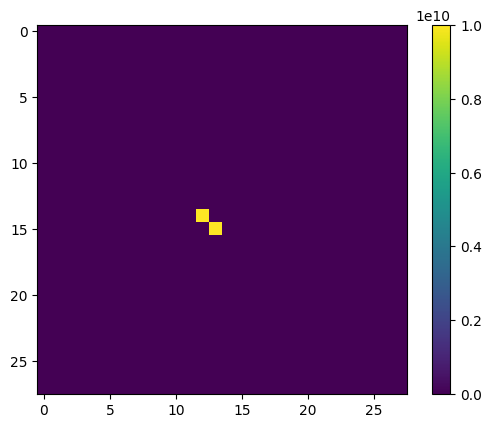

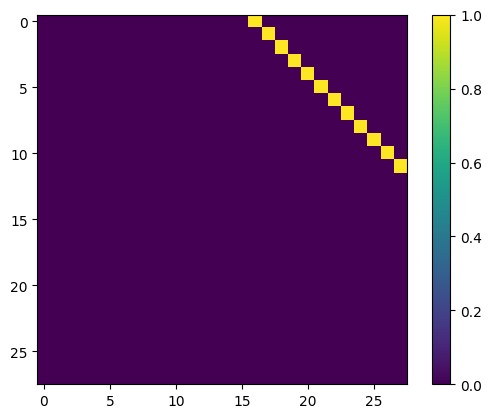

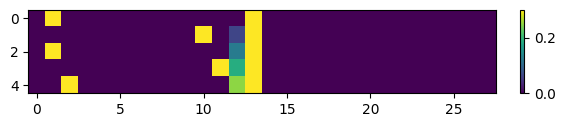

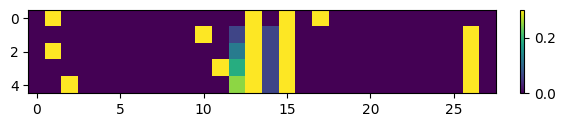

In [13]:
plus_pos = Register('plus_pos', 2)
plus_copy = Register('plus_copy', len(tokens))

embedding = EmbeddedState(tokens, [pos, plus_pos, plus_copy])
find_plus = FindToken(embedding, '+', plus_pos)
copy_plus = GetTokenAt(embedding, plus_pos, plus_copy)

plot_tensor(copy_plus.q)
plot_tensor(copy_plus.v)

x = embedding.embed(embedding.tokenize('1+1=2'))
plot_tensor(x, vmax=0.3)
after_find_plus = find_plus.forward(x.unsqueeze(0))
after_copy_plus = copy_plus.forward(after_find_plus)
plot_tensor(after_copy_plus[0], vmax=0.3)


As you can see, the tokens on the right are the original tokens shifted forward by one step.

This turns out to be the last attention-based instruction we need. 

<a name="Fully-Connected-Layers"></a>
## Fully Connected Layers

The remaining instructions are much more traditional fully connected layers. Another name for this is "Multi Layer Perceptron" which I've used to name the base class (it sounds fancy).

In GPT-class models, the fully connected pieces first use a layer that maps the token state to something 4x wider, adds a bias, passes things through a GELU activation function and then maps these dimensions back down to the original token state size (again, with a bias). It turns out we generally don't need 4x the width for our purposes so I leave it up to the instruction to choose how wide or narrow the intermediate layer is.

In [14]:
class MLPLayer(torch.nn.Module):
    def __init__(self, w1, b1, w2, b2, debug=False):
        super().__init__()
        self.debug = debug
        
        self.w1 = torch.nn.Parameter(w1)
        self.b1 = torch.nn.Parameter(b1)
        self.w2 = torch.nn.Parameter(w2)
        self.b2 = torch.nn.Parameter(b2)
        
        self.gelu = torch.nn.GELU()
        
    def forward(self, seq):
        a = self.gelu(seq @ self.w1 + self.b1)
        if self.debug:
            plot_tensor(a[0])
        b = (a @ self.w2)
        if self.debug:
            plot_tensor(b[0])
        x = b + self.b2
        if self.debug:
            plot_tensor(x[0])
        return seq + x

Now, let's start with an easy example of a fully connected layer to clear out a register

### Clear

This layer simply:
- Scales up the register(s) in question to avoid the nonlinearies around 0
- Passes ths through the activation layer unharmed
- Scales things back down and flips the sign so that when the layer's output is added to the state the relevant registers go to zero

To be frank: this is kind of a painful way to clear a register. Ideally one could just skip the activation function entirely, but in the spirit of keeping things analogous to real transformers we work around them instead.


In [15]:
class Clear(MLPLayer):
    def __init__(self, 
            embedding: EmbeddedState, registers: list[Register]):
        w1 = torch.zeros(embedding.dim, embedding.dim)
        b1 = torch.zeros(embedding.dim)
        w2 = torch.zeros(embedding.dim, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        
        for reg in registers:
            for i in range(reg.size):
                w1[reg.offset + i, reg.offset + i] = 100.0
        
        for reg in registers:
            for i in range(reg.size):
                w2[reg.offset + i, reg.offset + i] = -0.01
    
        super().__init__(w1, b1, w2, b2)

As an example:

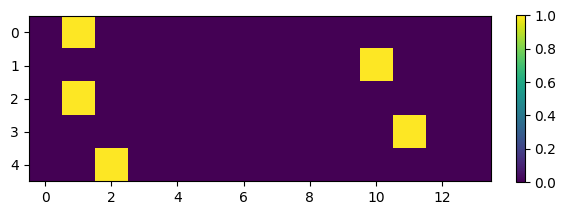

In [16]:
tokens = list('0123456789+=')
pos = Register('pos', 2)

embedding = EmbeddedState(tokens, [pos])
clear = Clear(embedding, [pos])
x = embedding.embed(embedding.tokenize('1+1=2'))
plot_tensor(clear.forward(x.unsqueeze(0))[0])

No more position!

Now that we're warmed up, we can take on the big kahuna...

### Single Digit Add

The goal of this "instruction" is to take two digits and a carry state and emit the output digit and then modify the carry state as appropriate.

Multilayer networks can do a lot of different things, but in our case we use it as a form of key-value lookup. To do so, we compute every permutation of the left digit, right digit and carry state, then we create a neuron that takes the sum of the one-hot values (scaled up) and the carry state (or inverse carry state, depending on the context). If this exceeds some threshold then that neuron "activates" and outputs the correct resulting digit and carry state modifications.

In [17]:
class SingleDigitAdd(MLPLayer):
    def __init__(self,
        embedding: EmbeddedState, left_token: Register, right_token: Register, carry: Register, out_token: Register,
    ):
        hidden = 10 * 10 * 2
        w1 = torch.zeros(embedding.dim, hidden)
        b1 = torch.zeros(hidden)
        w2 = torch.zeros(hidden, embedding.dim)
        b2 = torch.zeros(embedding.dim)

        MATCH = 100 # can be any large enough number
        BIAS = MATCH * 0.9
        ACTIVATED = MATCH - BIAS # the expected matching neuron value after activation function
        for i in range(10):
            for j in range(10):
                for c in range(2):
                    idx = i*10*2 + j*2 + c

                    # match key (left, right, carry)
                    w1[left_token.offset + i, idx] = MATCH / (2 + c)
                    w1[right_token.offset + j, idx] = MATCH / (2 + c)
                    w1[carry.offset, idx] = (c - 1) * MATCH + c * (MATCH / (2 + c))
                    b1[idx] = -BIAS # this ensures only full match passes the GeLU activation

                    # write value (out, carry)
                    w2[idx, out_token.offset + (i + j + c) % 10] = 1 / ACTIVATED
                    new_c = int((i + j + c) >= 10)
                    c_update = new_c - c
                    w2[idx, carry.offset] = c_update * (1 / ACTIVATED)

        super().__init__(w1, b1, w2, b2)

This is a little complicated to demonstrate without all the other machinery, but to start you can see the weights (they're pretty!)

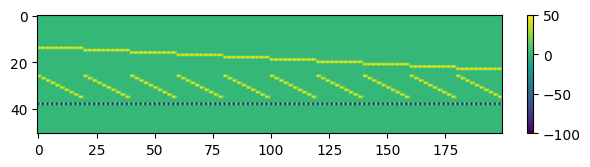

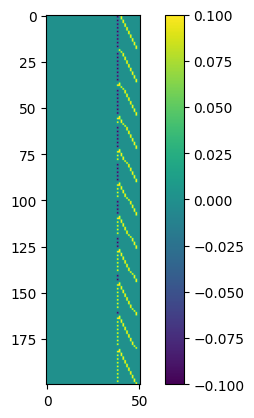

In [18]:
tokens = list('0123456789+=')
pos = Register('pos', 2)
left = Register('left', len(tokens))
right = Register('right', len(tokens))
carry = Register('carry', 1)
out = Register('out', len(tokens))

embedding = EmbeddedState(tokens, [pos, left, right, carry, out])
single_digit_add = SingleDigitAdd(embedding, left, right, carry, out)

plot_tensor(single_digit_add.w1)
plot_tensor(single_digit_add.w2)

The remaining instructions are fairly specific to our use case. The next two in particular are intended to be used in tandem to determine if two positions are the same.

### Diff Position

This returns a "difference" between two positions. The reason "difference" is in quotes is because I have yet to figure out how to use one position to rotate another position (in order to compute a difference) so this is a crude approximation that effectively computes:

```
z1 = activation(100*x1 + 1000*y1 - x2*100 - y2*1000)
z2 = activation(100*x2 + 1000*y2 - x1*100 - y1*1000)
out = z1 + z2
```

The reason we do this twice with different signs is so that the activation function doesn't zero out the difference of one if its negative. The resulting unit is not meaningful, but we really only care that things are nonzero.

In [19]:
class DiffPos(MLPLayer):
    def __init__(self,
            embedding: EmbeddedState, pos1: Register, pos2: Register, diff: Register):
        w1 = torch.zeros(embedding.dim, 2)
        b1 = torch.zeros(2)
        w2 = torch.zeros(2, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        
        # Note: it's important that the pos[0] and pos[1] are multiplied by different numbers,
        # otherwise [x, y] computes to be the same as [y, x]
        
        w1[pos1.offset, 0] = 1e2
        w1[pos1.offset + 1, 0] = 1e3
        w1[pos2.offset, 0] = -1e2
        w1[pos2.offset + 1, 0] = -1e3

        w1[pos1.offset, 1] = -1e2
        w1[pos1.offset + 1, 1] = -1e3
        w1[pos2.offset, 1] = 1e2
        w1[pos2.offset + 1, 1] = 1e3
        
        w2[0, diff.offset] = 1.0
        w2[1, diff.offset] = 1.0
        
        super().__init__(w1, b1, w2, b2)

For brevity we'll skip the demonstration and move on to 

### Is Zero

This instruction performs the following calculation to determine if a register is approximately zero and replace the register with the outcome:

```
z1 = activation(-100*x + 10)
z2 = activation(x)
out = 0.1*z1 - z2
```

Since this is used in tandem with the previous layer we know that x is positive. The output of the first neuron is used to make sure that the input is between 0 and 0.1 (which counts as close enough to zero). The second neuron is used to store the original input so we can later flip it and use it to zero out the input register and replace it with the scaled down output from the first neuron.

In [20]:
class IsZero(MLPLayer):
    def __init__(self, 
            embedding: EmbeddedState, zero: Register):
        w1 = torch.zeros(embedding.dim, 2)
        b1 = torch.zeros(2)
        w2 = torch.zeros(2, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        
        w1[zero.offset, 0] = -100.0
        b1[0] = 10.0
        w1[zero.offset, 1] = 1.0
        
        w2[0, zero.offset] = 0.1
        w2[1, zero.offset] = -1.0
        
        super().__init__(w1, b1, w2, b2)

Second to last, we have

### Copy on Match

The function of this layer is to move one register to another if the match register is one. The way this works is that for every column of the source register, we multiply it by 100 and add it to the match register times 100. We then subtract 190 and pass it through activation before scaling it down. This way, the output to the destination register is only non-zero _**if both**_ the match is positive and non-zero **and** the particular token column is nonzero.

In [21]:
class ConditionalCopy(MLPLayer):
    def __init__(self, 
            embedding: EmbeddedState, 
            cond: Register, 
            src: Register, 
            dst: Register):
        w1 = torch.zeros(embedding.dim, src.size)
        b1 = torch.ones(src.size)
        w2 = torch.zeros(src.size, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        
        for i in range(src.size):
            w1[cond.offset, i] = 100
            w1[src.offset + i, i] = 100
            b1[i] = -190
        
        for i in range(src.size):
            w2[i, dst.offset + i] = 0.1
            
        super().__init__(w1, b1, w2, b2)

And with that we've got our final fully connected instruction left:

### Step Position

This one is a little bit easier on the mind: it just moves a particular position register forward or backward a fixed number of steps. It does this with a 2d rotation matrix and then adds a whole bunch of bias to make sure the activation function doesn't mess with the position. After the activation it then removes this bias.

In [22]:
class StepPosition(MLPLayer):
    def __init__(
            self, embedding: EmbeddedState, positions: list[Register], offsets: list[Register]):
        assert len(positions) == len(offsets)
        rotation = torch.zeros(embedding.dim, embedding.dim)
        
        for i in range(len(positions)):
            reg = positions[i]
            offset = offsets[i]
            
            sin = math.sin(-offset*(2*math.pi)/100)
            cos = math.cos(-offset*(2*math.pi)/100)
        
            rotation[reg.offset, reg.offset] = cos - 1
            rotation[reg.offset + 1, reg.offset] = -sin
            rotation[reg.offset, reg.offset + 1] = sin
            rotation[reg.offset + 1, reg.offset + 1] = cos - 1

        w1 = rotation
        # adding and then removing bias to prevent the GELU from zeroing negative vs
        b1 = torch.ones(embedding.dim)*10
        w2 = torch.eye(embedding.dim, embedding.dim)
        b2 = torch.ones(embedding.dim)*-10
        
        super().__init__(w1, b1, w2, b2)

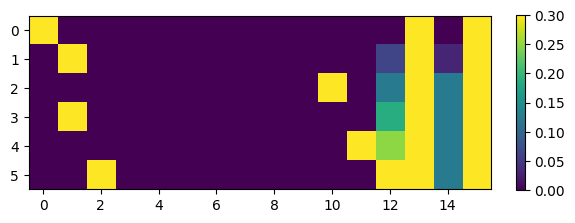

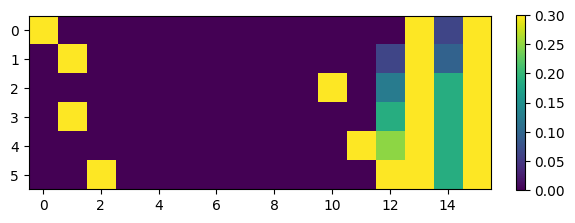

In [23]:
some_pos = Register('some_pos', 2)
embedding = EmbeddedState(tokens, [pos, some_pos])
find_plus = FindToken(embedding, '+', some_pos)
step_left = StepPosition(embedding, [some_pos], [1])

x = embedding.embed(embedding.tokenize('01+1=2'))
x = find_plus.forward(x.unsqueeze(0))
plot_tensor(x[0], vmax=0.3)
x = step_left.forward(x)
plot_tensor(x[0], vmax=0.3)

<a name="Our-First-Algorithm"></a>
# Our First Algorithm

One of the things you quickly realize when trying to engineer a transformer is that **in order to perform complex computation between tokens, you generally need to copy state from one token to another token**. 

As an example, in order to add the first digit of the left operand to the first digit of the right operand, it's easiest to move the value of each token into a single token before you can consider both against each other.

The second thing you realize is that **only the last token's state "matters"** in the end because it's what is used to generate the next token.

Given this, our first naive approach is as follows (from the perspective of each individual token):

- Find and store the position of the plus sign in a 'left_cursor' register
- Find and store the position of the equal sign in a 'right_cursor' register
- Find and store the position of the equal sign in an 'out_cursor' register
- Increment the position of the 'out_cursor' register by one position
- For each digit we want to add (4 in our case):
  - Clear registers that store any previously used 'left', 'right' and 'out' digits
  - Move the left and right cursor one token to the left. Move the out cursor one token to the right.
  - Copy the tokens specified at the left and right cursors into left and right token registers.
  - Perform single digit addition, reading from the left and right token registers and a carry register, writing to an out token register.
  - If the out cursor is pointing at the same position as the original token position, copy the out token to the final token
- Finally, we take the output of the final_token and relocate it back to the original token position so it can be read as the next token to generate

It might be counter intuitive that we need to keep track of a "final" token in additional to an "out" token. The reason for this is that each token actually does the whole addition (because every layer of the stack does the same operations). Given this, we need to keep track of when the out digit is referring to the token undergoing computation and if so save it off for later.

A few important notes:
- A traditional transformer alternates between attention layers and fully connected layers. This work uses what's needed when its needed. This is functionally equivalent, however, because layers can easily be ignored in a residual network.
- *This is not an efficient algorithm.* It's the first algorithm I got to work.
- *It intentionally does computation symbolically, rather than by converting numbers to activations.* This is because I wanted to approximate an implementation that was "conceptual" rather than mathematical.

Now, let's put it all together!

In [24]:
tokens = list('0123456789+=')
pos = Register('pos', 2)
left_pos = Register('left_pos', 2)
right_pos = Register('right_pos', 2)
out_pos = Register('out_pos', 2)
left_digit = Register('left', len(tokens))
right_digit = Register('right', len(tokens))
out_digit = Register('out', len(tokens))
final_digit = Register('final', len(tokens))
carry = Register('carry', 1)
distance_cond = Register('distance_cond', 1)

embedding = EmbeddedState(tokens, [pos, left_pos, right_pos, out_pos, left_digit, right_digit, out_digit, carry, distance_cond, final_digit])

class PaddedAddition(torch.nn.Module):
    def __init__(self):
        super(PaddedAddition, self).__init__()
        self.debug = False

        # Attention layer to search for the location of various tokens
        self.find_plus = FindToken(embedding, '+', left_pos)
        self.find_equal = FindToken(embedding, '=', right_pos)
        self.find_out = FindToken(embedding, '=', out_pos)

        # Fully connected layers to adjust positions by fixed amounts
        self.step_out = StepPosition(embedding, [out_pos], [-1])
        
        # Note: I've unrolled this because I was concerned the reuse of weights would do weird things with
        # backprop
        self.clear_lro = Clear(embedding, [left_digit, right_digit, out_digit])
        self.step_pos = StepPosition(embedding, [left_pos, right_pos, out_pos], [-1, -1, 1])
        self.read_left = GetTokenAt(embedding, left_pos, left_digit)
        self.read_right = GetTokenAt(embedding, right_pos, right_digit)
        self.single_digit_add = SingleDigitAdd(embedding, left_digit, right_digit, carry, out_digit)
        self.diff_pos = DiffPos(embedding, pos, out_pos, distance_cond)
        self.is_zero = IsZero(embedding, distance_cond)
        self.copy_out = ConditionalCopy(embedding, distance_cond, out_digit, final_digit)

        # Linear layer to move the final digit to the out digit
        self.final_projection = torch.zeros(embedding.dim, final_digit.size)
        for i in range(final_digit.size):
            self.final_projection[final_digit.offset + i, i] = 1.0e6
        self.final_projection = torch.nn.Parameter(self.final_projection)
        
        self.softmax = torch.nn.Softmax(1)

    def generate(self, input_string):
        x = embedding.embed(embedding.tokenize(input_string))
        x = self(torch.unsqueeze(x, 0).to(self.final_projection.device))
        return input_string + embedding.predict(x[0].detach())

    def forward(self, x):
        # Map here is a tensor that keeps track of the various activations through one
        # auto-regressive pass
        self.map = torch.zeros((x.shape[1] + 1)*9, embedding.dim)
        s = 0
        
        if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1

        x = self.find_plus.forward(x)
        
        if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1
        
        x = self.find_equal.forward(x)
        
        if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1
            
        x = self.find_out.forward(x)
        
        if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1
            
        x = self.step_out.forward(x)
        
        if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1

        for i in range(4):
          x = self.clear_lro.forward(x)
          x = self.step_pos.forward(x)
          x = self.read_left.forward(x)
          x = self.read_right.forward(x)
          x = self.single_digit_add.forward(x)
          x = self.diff_pos.forward(x)
          x = self.is_zero.forward(x)
          x = self.copy_out.forward(x)

          if self.debug:
            self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
            s += 1
            
        x = x @ self.final_projection
            
        return x
    
    def to(self, device):
        super(PaddedAddition, self).to(device)

Now, let's give it a go and see if it works! (It will)

In [25]:
m = PaddedAddition()
test = random_addition()
print("Expected output:", test)
test = test.split('=')[0] + '='
m.debug = True
for i in range(4):
    test = m.generate(test)
    print(test)

Expected output: 0945+0265=0121
0945+0265=0
0945+0265=01
0945+0265=012
0945+0265=0121


Because I've turned on debug, we keep track of (some of) the states between layers / instructions.

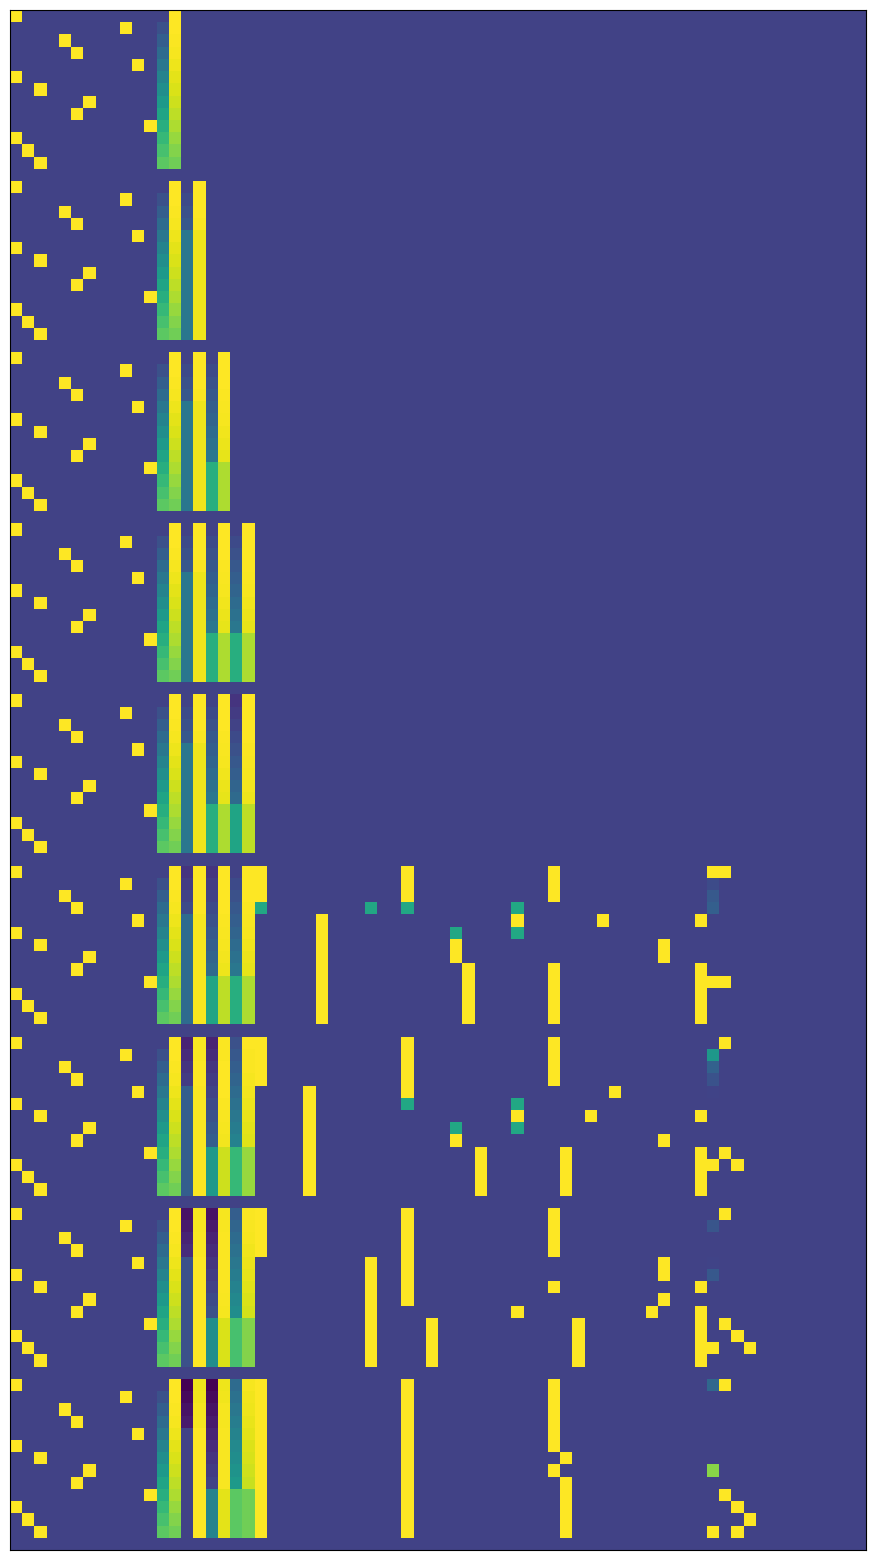

In [26]:
plot_tensor_array(m.map.unsqueeze(0).detach())

Hopefully you recognize some parts of this from above, but to point out a few things explicitly:
    
- On the left we start with tokens and positions
- Then we have a bank of cursors that point to where particular tokens are
- After that we have tokens copied from relevant positions into local registers
- Then we have the output token and the final token

You'll note that all tokens at or after the equal sign have identical activations except for the final token. They're all performing the same computations!

<a name="Reflections"></a>
# Reflections

## Computational Capacity and Trainability

There's a concept in information theory called "information capacity" that defines the maximum amount of information that can pass through a channel without error. The channel in this case is something like a wire or a radio wave that has certain loss characteristics and noise. There's a fundamental limit to how much information can move given these characteristics defined in what's known as the Shannon-Hartley Theorem. The specific details aren't relevant, but finding algorithms to _reach_ this theoretical limit has been the focus of extensive research orver decades. In that case, with coding schemes like Low Density Parity Check codes we can get _pretty close_.

I find myself wanting for a similar framework in machine learning:

1. Given a particular architecture, is a certain kind of capability theoretically computable given any possible weight configuration?
2. Can we actually train a model from scratch to realize this capability?

For this architecture, the answer to (2) is yes (to come in a later post), but I theorize that at smaller scales with modern methods (2) might start to extend beyond our reach. The intuition here is basically that the lottery ticket hypothesis is critical for working around local minima and as such requires massive overparameterization (that can later be pruned out).

## Iteration

The way in which long addition works is one in which we repeat the same step over and over again. Despite the fact that a Transformer generates one token after another, the computation itself is _not_ by default recursive. If you sat down to design an addition algorithm like I did you might think "ok, I'm going to compute each digit one by one and then pass off the carry state to the model for it to compute the next token." The problem is: this is really hard!

To make this a bit more obvious, here's a visual representation of the process by which we generate tokens:

![Figure 1](https://github.com/newhouseb/handcrafted/blob/main/figure1.png?raw=true)

The insight that this diagram (hopefully) provides is that if the model can learn to approximate relevant future state in a generated token, we can effectively utilize our "instruction set" recursively! To me, this is an interesting way to frame "chain of thought" reasoning. It's not just about working in smaller steps, it's giving the model access to massively more compute to solve the problem (if it can figure out how to pass context through tokens). In the literature, this is called "giving the model a scratchpad."

All that being said: for this experiment it was simplest to just duplicate the critical layers one time for each digit we expect to add. As a future exercise, it would be interesting to see if one could hand-design a model to add infinite digits by storing intermediate state in the token output. 

To make that a little more clear, you might design a model to emit a carry state after each digit that could then be read in, say by using a `!` to represent a carry and `_` to represent no carry:

```
  019+ 003=2!2_0_
```

## Multiplication And Rotation

In this toy network we use a rotated vector to store position. This is for a couple reasons:

- In traditional transformers there's a lot of normalization happening and if you used absolute values that happen to be the largest activation on a layer you would frequently find your positions are normalized out.
- Rotated unit vectors provide an easy way to check equivalence because the dot product of unit vectors is 1 if they're the same and less if they're not. This is particularly useful when trying to pull out state from a specific token based on a position.

The challenge comes when we want to rotate one state position by _another state position_ to compute a distance between tokens. 

As one example, each token after the `=` would ideally compute a distance from said `=` in order to know which decimal place a given token signifies (i.e. ones, tens, hundreds, etc). As compared to a fixed rotation against a part of the residual stream, a dynamic rotation requires performing multiplications with _multiple_ inputs from the residual stream.

"Aha", you say, "self-attention effectively performs 'self multiplication'!" You would be correct. Immediately after, however, it runs everything through softmax which makes everything sum up to 1. I would imagine that there's some "trick" here that allows you to scale things back after the fact to their pre-normalized values... but I have yet to figure it out.

It's worth acknowledging that multi-layer perceptrons are be able to approximate any function and could ostensibly be configured to approximate a dynamic rotation. That said, it feels like some form of non-normalized self-attention could be a very useful primitive to give to a model to learn.

## Interpretability

In writing all of this up, it's interesting to think about what current interpretability methods would "reverse-engineer" from this heavily engineered model. After all, what's behind this model is not "some alien form of intelligence" but rather a very human form of intelligence (me).

A lot of interpretability approaches attempt to answer the question of "what does this specific neuron" do. In this model, finding meaning in a single weight would be a very hard without zooming way out. A much better approach (in this case) would be to figure out what the various columns in the token states represent between layers.

Perhaps when evaluating interpretability methods it might make sense to evaluate them against models designed by human intelligence (to the extent that we can design models up to a certain scale).

<a name="Further-Reading"></a>
# Further Reading

A lot of people have been doing fantastic work in interpreting models and there's a few that I want to highlight as being particularly relevant or interesting to this work.

## [Thinking Like Transformers](https://srush.github.io/raspy/) 

This work derives a "language" called RASP that abstracts away what's possible with transformers and uses it design programs to perform a variety of basic tasks like reversing a string. This is basically a much more academic version of the above from a few years ago before we were all on the transformer bandwagon.

## [Learning Transformer Programs](https://arxiv.org/pdf/2306.01128.pdf)

This one is hot off the press (as of this writing) but also ridiculously cool: they add constraints to transformer models to force "hard" attention that is more interpretable than typically learned algorithms. They can then "decompile" the learned weights into Python (!). The Python is not always interpretable but it's still super cool.

## [Teaching Algorithmic Reasoning via In-Context Learning](https://arxiv.org/pdf/2211.09066.pdf)

This is a fun paper that (among other things) teaches LLMs to add two numbers step by step by providing in-context demonstrations of long-hand addition. In-context "learning" is an interesting thing to think about given the above exploration: it's as if the model has "learned" to match previously executed instructions and re-execute them against later tokens.

## [Transformer Circuits](https://transformer-circuits.pub/)

This is the grandaddy of transformer interpretability work and is what got me so jazzed to do something like this in the first place. Start with "A Mathematical Framework for Transformer Circuits."

----

# Output result in natural (not reversed) order

Let's handcraft some more layers to output the digits of the result in the natural order (as the `PaddedAddition` model above outputs the digits in reverse).

The gist of the change is:
- extend the embedding with 4 new registers to store the (1-hot) encoding of the result digits.
- add new layers that will store all digit addition results into these registers.
- when outputting the token for generation, read it from the stored result registers in the right order given current output position

## (unconditional) Copy instruction

In the original implementation `ConditionalCopy()` was used to copy one register to another given a third condition register.

We now need another simpler version of this instruction, to perform the copy unconditionally. We'll use to store the addition results in the result registers.

In [27]:
class Copy(MLPLayer):
    def __init__(self, 
            embedding: EmbeddedState, src: Register, dst: Register):
        w1 = torch.zeros(embedding.dim, src.size)
        b1 = torch.zeros(src.size)
        w2 = torch.zeros(src.size, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        
        for i in range(src.size):
            w1[src.offset + i, i] = 1.15
        
        for i in range(src.size):
            w2[i, dst.offset + i] = 1
            
        super().__init__(w1, b1, w2, b2)

The `w1` matrix extracts the src register encoding from the embedding into the hidden layer, then the `w2` sets the hidden values in the destination register offset.

We use values of 1.15 instead of 1 in `w1` to accommodate the `GeLU` activation. 

Let's check it works as expected:

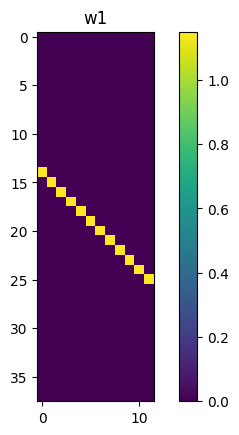

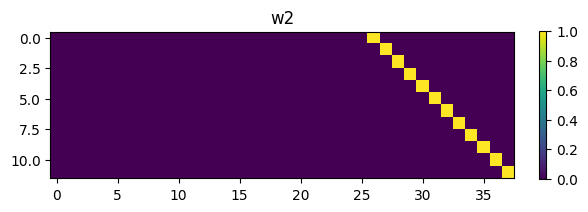

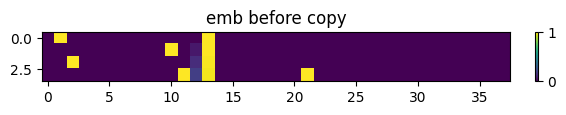

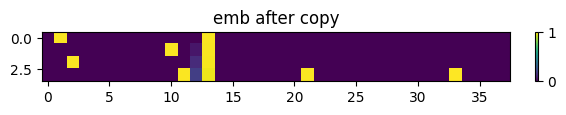

In [28]:
tokens = list('0123456789+=')
pos = Register('pos', 2)
reg1 = Register('reg1', len(tokens))
reg2 = Register('reg2', len(tokens))
embedding = EmbeddedState(tokens, [pos, reg1, reg2])

copy = Copy(embedding, reg1, reg2)

plot_tensor(copy.w1, title="w1")
plot_tensor(copy.w2, title="w2")

x = embedding.embed(embedding.tokenize('1+2=')).unsqueeze(0)
x[-1, -1, reg1.offset:reg1.offset + reg1.size] = \
    embedding.one_hot(embedding.tokenize('7'))

plot_tensor(x[0], title="emb before copy")
x = copy.forward(x) # can set copy.debug=True to see more plots
plot_tensor(x[0], title="emb after copy")

## Helper modules for more declarative implementation

A small refactor can help the extended implementation be easier to follow.

We'll stack all the instructions declaratively and also make it look a little more as a traditional transformer decoder. As @newhouseb mentioned above, the original implementation doesn't alternate between attention & MLP layers as a traditional transformer altough it's functionally equivalent, because layers can be ignored if they don't write to the residual stream. We'll make it more explicit by implementing a `Block` module and NOP attention & mlp layers:


In [29]:
class NopAttention(AttentionLayer):
    def __init__(self, embedding: EmbeddedState):
        q = torch.zeros(embedding.dim, embedding.dim)
        k = torch.zeros(embedding.dim, embedding.dim)
        v = torch.zeros(embedding.dim, embedding.dim)
        super().__init__(q=q, k=k, v=v)

class NopMLP(MLPLayer):
    def __init__(self, embedding: EmbeddedState):
        hidden_dim = 1
        w1 = torch.zeros(embedding.dim, hidden_dim)
        b1 = torch.zeros(hidden_dim)
        w2 = torch.zeros(hidden_dim, embedding.dim)
        b2 = torch.zeros(embedding.dim)
        super().__init__(w1, b1, w2, b2)


class Block(torch.nn.Module):
    def __init__(self, 
            embedding: EmbeddedState, attention: AttentionLayer = None, mlp: MLPLayer = None):
        super().__init__()
        self.attention = attention or NopAttention(embedding)
        self.mlp = mlp or NopMLP(embedding)
        
    def forward(self, seq):
        x = self.attention.forward(seq)
        x = self.mlp.forward(x)
        return x


nop_block = Block(embedding)
x = embedding.embed(embedding.tokenize('1+2'))
assert (x - nop_block.forward(x.unsqueeze(0))[0]).sum() == 0

Reimplementing the algorithm with the new helper modules:

In [30]:

tokens = list('0123456789+=')
pos = Register('pos', 2)
left_pos = Register('left_pos', 2)
right_pos = Register('right_pos', 2)
out_pos = Register('out_pos', 2)
left_digit = Register('left', len(tokens))
right_digit = Register('right', len(tokens))
out_digit = Register('out', len(tokens))
final_digit = Register('final', len(tokens))
carry = Register('carry', 1)
distance_cond = Register('distance_cond', 1)

embedding = EmbeddedState(tokens, [
    pos, 
    left_pos, 
    right_pos, 
    out_pos, 
    left_digit, 
    right_digit, 
    out_digit, 
    carry, 
    distance_cond, 
    final_digit])

class PaddedAddition(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.debug = False

        self.blocks = [
            Block(embedding, attention=FindToken(embedding, '+', left_pos)),
            Block(embedding, attention=FindToken(embedding, '=', right_pos)),
            Block(embedding, 
                  attention=FindToken(embedding, '=', out_pos), 
                  mlp=StepPosition(embedding, [out_pos], [-1])
                  ),
            *list(itertools.chain.from_iterable([
               [
                    Block(embedding, mlp=Clear(embedding, [left_digit, right_digit, out_digit])),
                    Block(embedding, mlp=StepPosition(embedding, [left_pos, right_pos, out_pos], [-1, -1, 1])),
                    Block(embedding, attention=GetTokenAt(embedding, left_pos, left_digit)),
                    Block(embedding, 
                        attention=GetTokenAt(embedding, right_pos, right_digit),
                        mlp=SingleDigitAdd(embedding, left_digit, right_digit, carry, out_digit)),
                    Block(embedding, mlp=DiffPos(embedding, pos, out_pos, distance_cond)),
                    Block(embedding, mlp=IsZero(embedding, distance_cond)),
                    Block(embedding, mlp=ConditionalCopy(embedding, distance_cond, out_digit, final_digit))
               ] for i in range(4)
            ])),
        ]

        # Linear layer to copy the final_digit to the actual token (index 0) of the embedding
        self.final_projection = torch.zeros(embedding.dim, final_digit.size)
        for i in range(final_digit.size):
            self.final_projection[final_digit.offset + i, i] = 1.0e6
        self.final_projection = torch.nn.Parameter(self.final_projection)
    
    def forward(self, x):
        for block in self.blocks:
            x = block.forward(x)

        return x @ self.final_projection

    def forward(self, x):
        # map here is a tensor that keeps track of the various activations through one
        # auto-regressive pass
        self.map = torch.zeros((x.shape[1] + 1)*len(self.blocks), embedding.dim)
        s = 0

        for block in self.blocks:
            x = block.forward(x)
        
            if self.debug:
                self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
                s += 1

        x = x @ self.final_projection
            
        return x

In [31]:
337+928

1265

In [32]:
def generate_next_token(model, input_string):
    x = embedding.embed(embedding.tokenize(input_string))
    x = model(torch.unsqueeze(x, 0))
    return embedding.predict(x[0].detach())

prompt = "0337+0928=" # 1265 (5621 reversed)
model = PaddedAddition()
for i in range(4):
    prompt += generate_next_token(model, prompt)
    print(prompt)

0337+0928=5
0337+0928=56
0337+0928=562
0337+0928=5621


In [33]:
test = random_addition()
q, reversed_a = test.split('=')
test = q + '=' + reversed_a
print("Expected output (reversed):", test)
test = test.split('=')[0] + '='
model = PaddedAddition()
model.debug = True
result = ""
print("Generate:")
for i in range(4):
    test += generate_next_token(model, test)
    print(test)
    result += test[-1]

assert result == reversed_a
print(f"\nlooks good!")

Expected output (reversed): 0309+0969=8721
Generate:
0309+0969=8
0309+0969=87
0309+0969=872
0309+0969=8721

looks good!


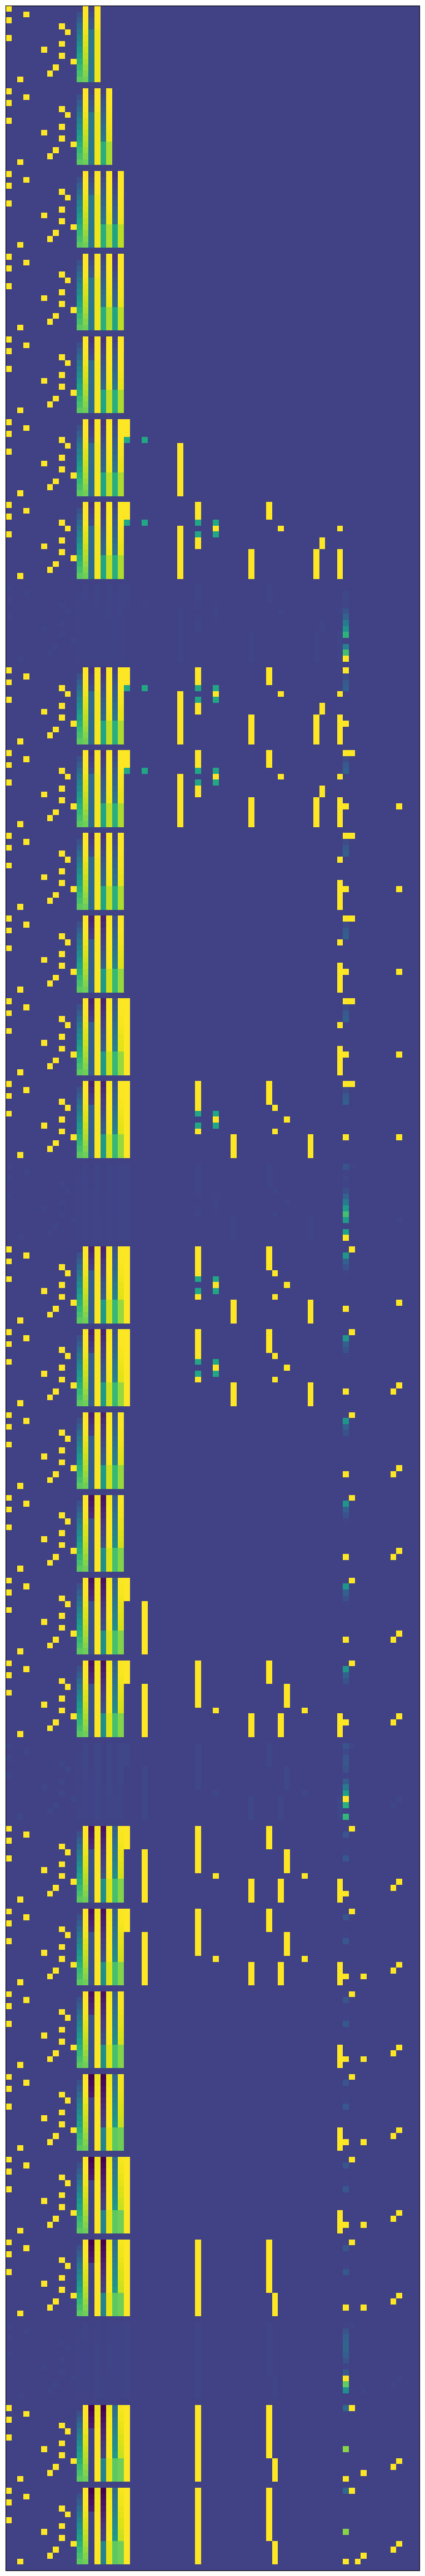

In [34]:
plot_tensor_array(model.map.unsqueeze(0).detach(), figsize=(80, 60))

## The extended implementation with un-reversed output

In [35]:
result_digits = [
    Register('result_' + str(i), len(tokens)) 
    for i in range(4)]
embedding = EmbeddedState(tokens, [
    pos, 
    left_pos, 
    right_pos, 
    out_pos,
    left_digit, 
    right_digit, 
    out_digit, 
    carry, 
    distance_cond, 
    final_digit, 
    *result_digits,])

class PaddedAdditionUnreversed(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.debug =  False
        self.blocks = [
            Block(embedding, attention=FindToken(embedding, '+', left_pos)),
            Block(embedding, attention=FindToken(embedding, '=', right_pos)),
            *list(itertools.chain.from_iterable([
               # for each left & right digit pair, we perform addition (with carry) and store the result in a result_register[i]
               [
                    Block(embedding, mlp=Clear(embedding, [left_digit, right_digit, out_digit])),
                    Block(embedding, mlp=StepPosition(embedding, [left_pos, right_pos], [-1, -1])),
                    Block(embedding, attention=GetTokenAt(embedding, left_pos, left_digit)),
                    Block(embedding, attention=GetTokenAt(embedding, right_pos, right_digit)),
                    Block(embedding, mlp=SingleDigitAdd(embedding, left_digit, right_digit, carry, out_digit)),
                    Block(embedding, mlp=Copy(embedding, out_digit, result_digits[i])),
               ] for i in range(4)
            ])),
            Block(embedding, 
                  attention=FindToken(embedding, '=', out_pos), 
                  mlp=StepPosition(embedding, [out_pos], [-1])
            ),
            *list(itertools.chain.from_iterable([
                # starting from the '=' sign, we move the `out_pos` position register to the right,
                #   if it's value matches the `pos` register (the positional encoding of currently decoded token)
                #   we copy the appropriate result digit to the `final_digit` register.
                [
                    Block(embedding, mlp=StepPosition(embedding, [out_pos], [1])),
                    Block(embedding, mlp=DiffPos(embedding, pos, out_pos, distance_cond)),
                    Block(embedding, mlp=IsZero(embedding, distance_cond)),
                    Block(embedding, mlp=ConditionalCopy(embedding, distance_cond, result_digits[i], final_digit))
                  # when `pos` shows we are i tokens after the `=` sign, then we need to output result_digit[3-i]
                  #   decreasing i while increasing `out_pos` gives us the desired match
                ] for i in reversed(range(4))
            ]))
        ]

        # Linear layer to copy the final_digit to the actual token (index 0) of the embedding
        self.final_projection = torch.zeros(embedding.dim, final_digit.size)
        for i in range(final_digit.size):
            self.final_projection[final_digit.offset + i, i] = 1.0e6
        self.final_projection = torch.nn.Parameter(self.final_projection)

    def forward(self, x):
        # Map here is a tensor that keeps track of the various activations through one
        # auto-regressive pass
        self.map = torch.zeros((x.shape[1] + 1)*len(self.blocks), embedding.dim)
        s = 0

        for block in self.blocks:
            x = block.forward(x)
        
            if self.debug:
                self.map[(x.shape[1] + 1)*s:(x.shape[1] + 1)*s + x.shape[1], :] = x[0] / torch.max(x[0])
                s += 1

        x = x @ self.final_projection
            
        return x

In [36]:
prompt = "0337+0928=" # 1265
model = PaddedAdditionUnreversed()
for i in range(4):
    prompt += generate_next_token(model, prompt)
    print(prompt)

0337+0928=1
0337+0928=12
0337+0928=126
0337+0928=1265


Let's test a random example:

In [37]:
test = random_addition()
q, reversed_a = test.split('=')
a = reversed_a[::-1]
test = q + '=' + a
print("Expected output (unreversed):\t", test)
test = test.split('=')[0] + '='
model = PaddedAdditionUnreversed()
model.debug = True
result = ""
print("Generate:")
for i in range(4):
    test += generate_next_token(model, test)
    print(test)
    result += test[-1]

assert result == a
print(f"\nlooks good!")

Expected output (unreversed):	 0021+0456=0477
Generate:
0021+0456=0
0021+0456=04
0021+0456=047
0021+0456=0477

looks good!


Let's look at the debug plot which traced the last forward pass:

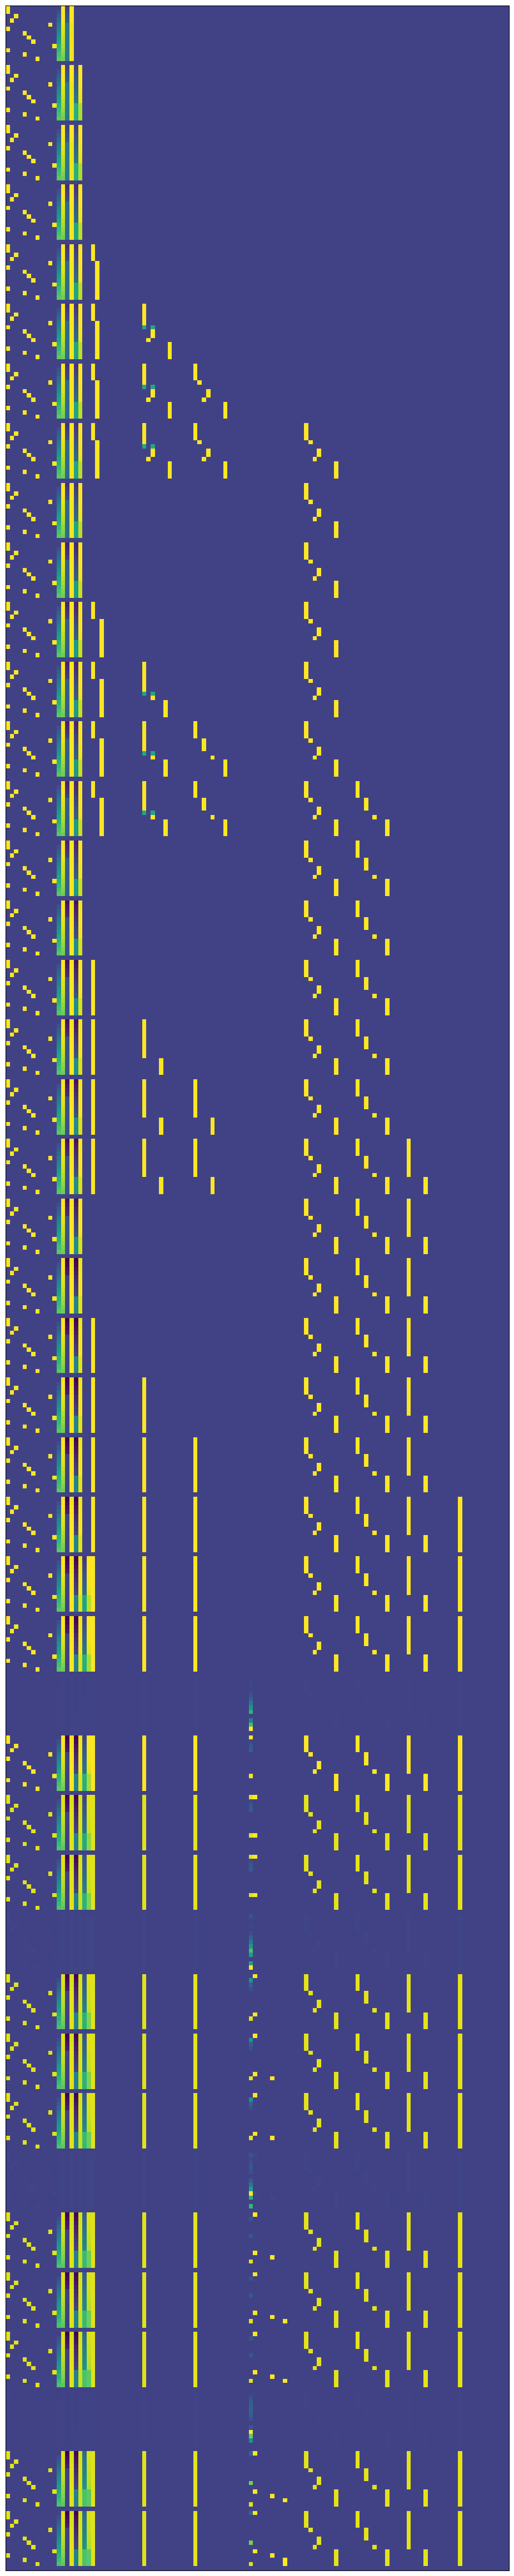

In [38]:
plot_tensor_array(model.map.unsqueeze(0).detach(), figsize=(80, 60))

Note that this plot is quite longer than the original implementation as now we append to the debug map after every block.

As we added 4 new `result_digit_*` registers (each taking 14 columns) the rows are wider. We can see that the new columns (last 54) get filled with what looks like the (1 hot) encoding of the numbers which are stored in these registers. These registers are filled early on in the forward pass - then the later layers deal with copying from one of these result registers to the `final_digit` register based on the next token output position in the sequence.

(note #2: The lines which look almost empty except one column show the state of the embedding after the `DiffPos()` block. It writes high values to the `distance_cond` register, and the normalization done to the `map` tensor almost "hides" the other register in the plot - but they are still there with same values. The follow-up `IsZero()` blocks sets a lower value in the `distance_cond` register so the plot becomes visible again)